<center><h1 style="text-align: center;"> Data Mining - Final Project </h1> </center>
<center><h3 style="text-align: center;"> Wind Power Supply for a wind farm </h3> </center>
<center><h5 style="text-align: center;"> Submitted by - Anand Prakash Saini </h5> </center>

### Introduction
This project aims to predict the Active Power (Patv) based on SDWPF dataset, using various machine learning models. The dataset consists of Columns: TurbID, Day, Tmstamp, Wspd, Wdir, Etmp, Itmp, Ndir, Pab1, Pab2, Pab3, Prtv, Patv. The objective is to compare the performance of different models and identify the most accurate one for predicting Active Power.
The rest of the report is as follows:
- Cleaning data

study the data and models for one turbine:

- Preprocessing
- Feature Selection
- Models
- Attempt to improve the model
- Result and evaluation

In [1]:
import utils
import evaluation
from linear_regression_model import LinearRegression
import numpy as np
from baseline_model import MovingAverage
from perceptron import Perceptron
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = utils.data_loader('./Project_data/wtbdata_245days.csv')

In [3]:
column = ", ".join(data.columns)
print('Columns Name:', column)

Columns Name: TurbID, Day, Tmstamp, Wspd, Wdir, Etmp, Itmp, Ndir, Pab1, Pab2, Pab3, Prtv, Patv


- Description of Columns:

| Column | Column Name | Specification                          |
|--------|-------------|----------------------------------------|
| 1      | TurbID      | Wind turbine ID                        |
| 2      | Day         | Day of the record                      |
| 3      | Tmstamp     | Created time of the record             |
| 4      | Wspd (m/s)  | The wind speed recorded by the anemometer |
| 5      | Wdir (°)    | The angle between the wind direction and the position of turbine nacelle |
| 6      | Etmp (°C)   | Temperature of the surrounding environment |
| 7      | Itmp (°C)   | Temperature inside the turbine nacelle |
| 8      | Ndir (°)    | Nacelle direction, i.e., the yaw angle of the nacelle |
| 9      | Pab1 (°)    | Pitch angle of blade 1                 |
| 10     | Pab2 (°)    | Pitch angle of blade 2                 |
| 11     | Pab3 (°)    | Pitch angle of blade 3                 |
| 12     | Prtv (kW)   | Reactive power                         |
| 13     | Patv (kW)   | Active power (target variable)         |


Let's see some statistical measeures of few columns to identify if there are outlliers in the data.

In [4]:
data[['Wspd','Prtv', 'Patv']].describe()

,Wspd,Prtv,Patv
count,4.678002e+06,4.678002e+06,4.678002e+06
mean,5.028376e+00,-1.323900e+01,3.504458e+02
std,3.393703e+00,7.044244e+01,4.249932e+02
min,0.000000e+00,-6.249800e+02,-9.330000e+00
25%,2.240000e+00,-3.861000e+01,-3.000000e-01
50%,4.340000e+00,-3.000000e-01,1.790800e+02
75%,7.010000e+00,-3.000000e-02,5.476600e+02
max,2.629000e+01,4.852000e+02,1.567020e+03


Handling some data caveats as described in the [paper](https://arxiv.org/pdf/2208.04360.pdf), such as Zero value, missinng values.

In [5]:
data = utils.handle_data_caveats(data)

Since the data contains 245 days of data from 134 turbines, it will be easier to visualize and try the models on one turbine and then for every turbine individually.

## Study one Turbine - Turbine1

### Preprocessing

1. Visualization

Number of records for Turbine-1:  34918


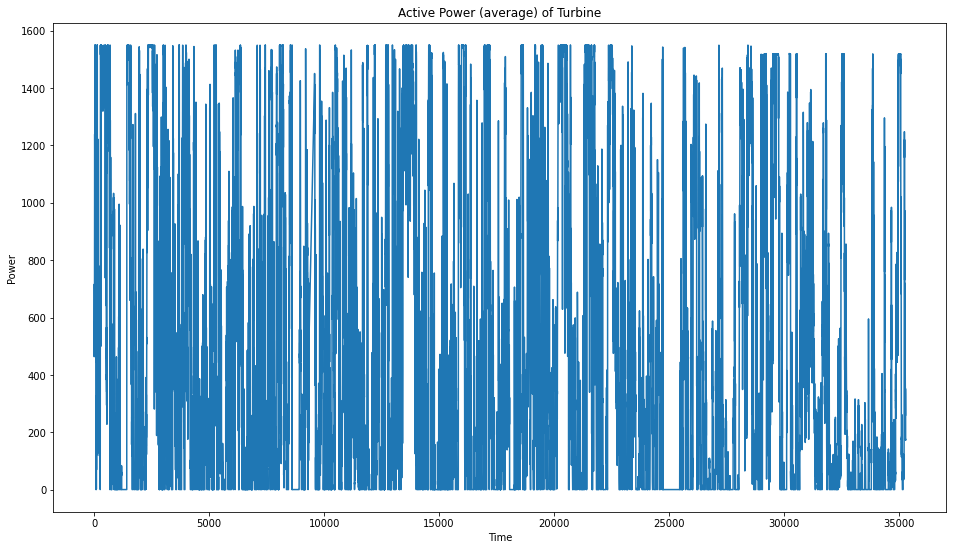

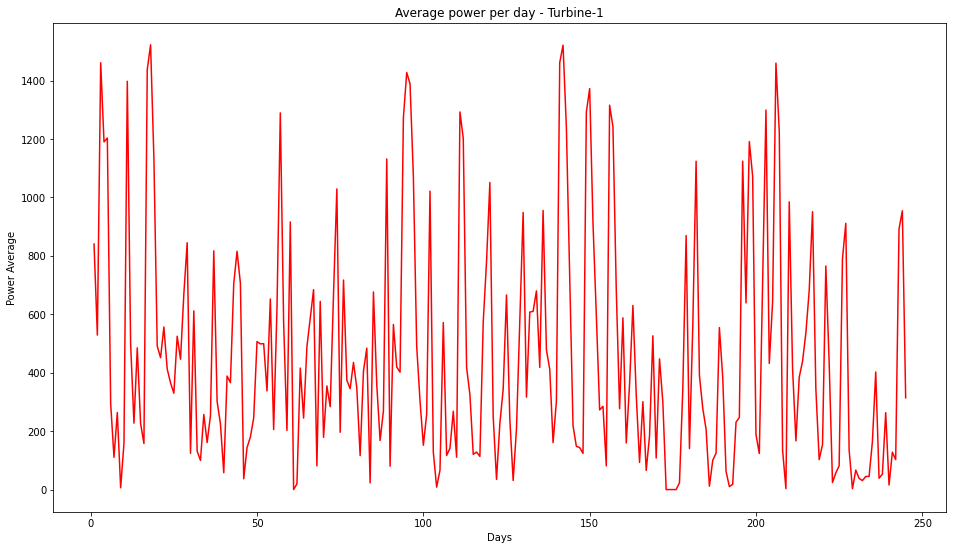

In [6]:
data_turbine_1 = utils.single_turbine_plots(data)

2. Detecting outliers in Patv values if any:

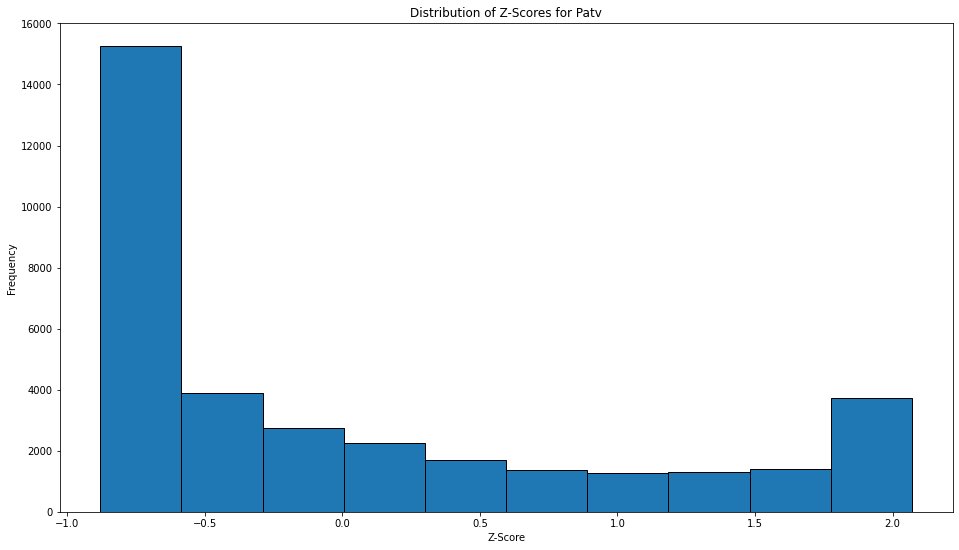

In [7]:
power_z_score = utils.calculate_zscore(data_turbine_1)

Patv does not seem to have outliers.

We now standardize the data as models are sensitive to higher values:

In [8]:
columns_to_standardize= ['Wspd', 'Etmp', 'Itmp', 'Pab1', 'Pab2', 'Pab3', 'Prtv']
standard_data_turbine_1 = utils.standardize_columns(data_turbine_1, columns_to_standardize)

### Feature Selection

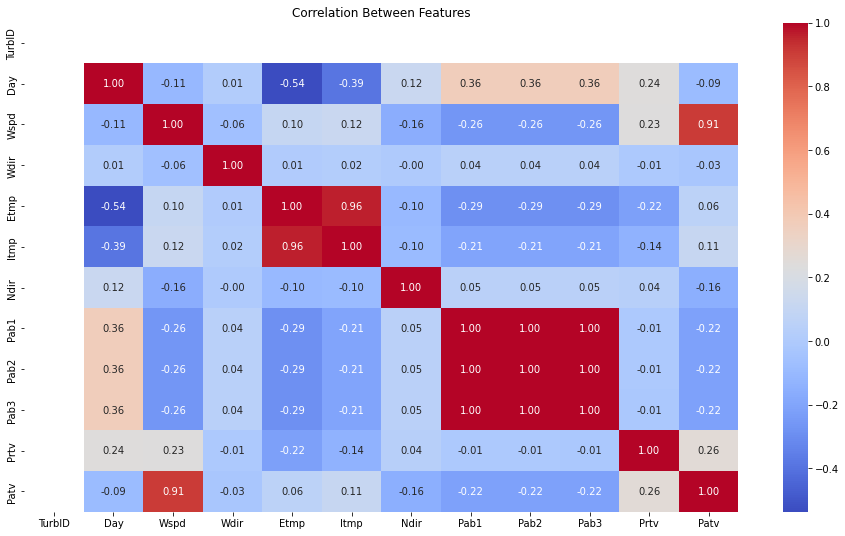

In [9]:
correlation = utils.calculate_correlation(standard_data_turbine_1)

Form the correlation heatmap we can infer that the Patv values are majorly correlated with the Wind speed as the corre;ation score is 0.91. This is an important feature for us to identify. The second most correlated is the reactive power.

### Models:

#### 1. Baseline model:

In [10]:
from baseline_model import MovingAverage

MA= MovingAverage(window_size=3)

test_patv_values, test_moving_average = MA.calculate_moving_average(data, 200, 45)
rmse, mae = evaluation.calculate_average_scores(test_patv_values, test_moving_average)
print("RMSE Value of the Baseline Model: ", rmse)
print("MAE Value of the Baseline Model: ", mae)

RMSE Value of the Baseline Model:  56.99403705927582
MAE Value of the Baseline Model:  29.136413213155098


#### 2. Linear Regression:

In [11]:
# Linear Regresion
LR_model = LinearRegression(learning_rate=0.01, num_iterations=1000)

train_x,train_y, val_x, val_y, test_x, test_y = utils.train_val_test_split(standard_data_turbine_1, 170,30,45)

X = np.array(train_x[['Wspd', 'Prtv']])
y = np.array(train_y)
val_x = np.array(val_x[['Wspd', 'Prtv']])
valy = np.array(val_y)
test_x = np.array(test_x[['Wspd', 'Prtv']])
test_y = np.array(test_y)

# Train the model
LR_model.fit(X, y)

# Make predictions on the validation set
val_pred_y_lr = LR_model.predict(val_x)

# Evaluate the model
LR_rmse, LR_mae = evaluation.calculate_average_scores (val_y, val_pred_y_lr)

print("RMSE Value of the LinearRegression: ", LR_rmse)
print("MAE Value of the LinearRegression: ", LR_mae)

RMSE Value of the LinearRegression:  362.20442654943645
MAE Value of the LinearRegression:  213.1939578751647


#### 3. Perceptron

In [12]:
perceptron = Perceptron(num_inputs=2, learning_rate=0.01)
perceptron.train(X,y, num_epochs=100)
y_pred_val_perceptron = perceptron.predict(val_x)
# Evaluate the model
per_rmse, per_mae = evaluation.calculate_average_scores (val_y, y_pred_val_perceptron)
print("RMSE Value of the Perceptron: ", per_rmse)
print("MAE Value of the Perceptron: ", per_mae)

RMSE Value of the Perceptron:  372.2137184008864
MAE Value of the Perceptron:  217.29739298206636


#### Attempt to improve the performance

1. Regularization - Lasso (l1) and Ridge(l2) regression
2. Multi layer perceptron


#### 4. Lasso

In [13]:
# Improvement attempt
# Lasso - l1
lasso = Lasso(alpha=10)
lasso.fit(X, y)
y_val_pred_lasso = lasso.predict(val_x)

# Evaluate the model
lasso_rmse, lasso_mae = evaluation.calculate_average_scores (val_y, y_val_pred_lasso)
print("RMSE Value of the Lasso: ", lasso_rmse)
print("MAE Value of the Lasso: ", lasso_mae)

RMSE Value of the Lasso:  358.4153080970153
MAE Value of the Lasso:  211.14281027027616


#### 5. Ridge

In [14]:
# Ridge -l2

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


ridge = Ridge(alpha=10)
ridge.fit(X, y)
y_val_pred_ridge = ridge.predict(val_x)

# Evaluate the model
ridge_rmse, ridge_mae = evaluation.calculate_average_scores (val_y, y_val_pred_ridge)
print("RMSE Value of the Ridge: ", ridge_rmse)
print("MAE Value of the Ridge: ", ridge_mae)


RMSE Value of the Ridge:  362.1313067590759
MAE Value of the Ridge:  213.15272757688936


#### 6. Multi Layer Perceptron

In [15]:
from mlp import train_mlp, predict_mlp

hidden_sizes = [16, 8]  # Example hidden layer sizes
learning_rate = 0.001
num_epochs = 2000
X = np.array(train_x[['Wspd', 'Prtv']])
y = np.array(train_y).reshape(-1,1)
weights, biases = train_mlp(X, y, hidden_sizes, learning_rate, num_epochs)
val_predictions = predict_mlp(val_x, weights, biases)

mlp_rmse, mlp_mae = evaluation.calculate_average_scores(np.array(val_y), np.array(val_predictions))
print("RMSE Value of the MLP: ", mlp_rmse)
print("MAE Value of the MLP: ", mlp_mae)

Epoch 100/2000, Loss: 499860.08268031536
Epoch 200/2000, Loss: 461287.67890038196
Epoch 300/2000, Loss: 429710.4256957622
Epoch 400/2000, Loss: 403859.7443216498
Epoch 500/2000, Loss: 382697.11427350744
Epoch 600/2000, Loss: 365372.3519559063
Epoch 700/2000, Loss: 351189.4555636065
Epoch 800/2000, Loss: 339578.6440334337
Epoch 900/2000, Loss: 330073.46676496044
Epoch 1000/2000, Loss: 322292.0645201378
Epoch 1100/2000, Loss: 315921.8286807115
Epoch 1200/2000, Loss: 310706.84256726236
Epoch 1300/2000, Loss: 306437.6002897397
Epoch 1400/2000, Loss: 302942.59009648516
Epoch 1500/2000, Loss: 300081.4040927615
Epoch 1600/2000, Loss: 297739.09751989244
Epoch 1700/2000, Loss: 295821.57098573307
Epoch 1800/2000, Loss: 294251.79013304925
Epoch 1900/2000, Loss: 292966.6908754617
Epoch 2000/2000, Loss: 291914.6458724738
RMSE Value of the MLP:  481.6814128763276
MAE Value of the MLP:  424.18431500254485


We use **Ridge** Regression model for the entire dataset and test set of 45 days.

In [16]:

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

data = utils.data_loader('C:/Users/shash/Desktop/Courses2022_23/Data Mining/Project/Project_data/wtbdata_245days.csv')

# Initialize a dictionary to store the results for each turbine
RMSE = {}
MAE = {}
# Loop through each unique turbine ID
for turb_id in data['TurbID'].unique():
    # Filter the data for the current turbine ID
    turbine_data = data[data['TurbID'] == turb_id]
    turbine_data = utils.handle_data_caveats(turbine_data)
    train_x,train_y, val_x, val_y, test_x, test_y = utils.train_val_test_split(turbine_data, 170,30,45)

    # Split the data into features (X) and target (y)
    X = np.array(train_x[['Wspd', 'Prtv']])
    y= np.array(train_y)
    test_x = np.array(test_x[['Wspd', 'Prtv']])
    test_y = np.array(test_y)
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    ridge = Ridge(alpha=0.1)
    
    ridge.fit(X_scaled, y)
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(test_x)

    y_pred = ridge.predict(X_test_scaled)
    
    # Calculate the MSE loss
    rmse, mae = evaluation.calculate_average_scores (test_y, y_pred)
    
    # Store the results for the current turbine ID
    RMSE[turb_id] = rmse
    MAE[turb_id] = mae
# Calculate the average MSE across all turbines
average_rmse = sum(RMSE.values()) / len(RMSE)
average_mae =  sum(MAE.values()) / len(MAE)

# Print the RMSE for each turbine and the average RMSE
for turb_id, rmse in RMSE.items():
    print(f"Turbine ID: {turb_id}, RMSE: {rmse}")
    
print(f"Average MSE: {average_rmse}")

# Print the MAE for each turbine and the average MAE
for turb_id, mae in MAE.items():
    print(f"Turbine ID: {turb_id}, MAE: {mae}")
    
print(f"Average MSE: {average_rmse}")    
print(f"Average MaE: {average_mae}")

Turbine ID: 1, RMSE: 176.63804710200813
Turbine ID: 2, RMSE: 201.5070360091767
Turbine ID: 3, RMSE: 195.53833170880014
Turbine ID: 4, RMSE: 198.05672708251177
Turbine ID: 5, RMSE: 271.3861024636972
Turbine ID: 6, RMSE: 192.6568936566707
Turbine ID: 7, RMSE: 200.23864268872
Turbine ID: 8, RMSE: 195.18087349665237
Turbine ID: 9, RMSE: 191.34526356394346
Turbine ID: 10, RMSE: 170.38745709821214
Turbine ID: 11, RMSE: 189.27661103155904
Turbine ID: 12, RMSE: 165.91753202956005
Turbine ID: 13, RMSE: 213.13475604457437
Turbine ID: 14, RMSE: 197.69204982404972
Turbine ID: 15, RMSE: 182.4124043214828
Turbine ID: 16, RMSE: 163.58551465058542
Turbine ID: 17, RMSE: 168.53763340288253
Turbine ID: 18, RMSE: 154.61753549957893
Turbine ID: 19, RMSE: 158.6467072714352
Turbine ID: 20, RMSE: 150.23212376957818
Turbine ID: 21, RMSE: 151.67105932828918
Turbine ID: 22, RMSE: 194.7490247939451
Turbine ID: 23, RMSE: 158.08279712660348
Turbine ID: 24, RMSE: 207.04307460911537
Turbine ID: 25, RMSE: 186.37457402